# MUWCLASS Pipeline on CSCv2 Demonstration
## see our paper at https://arxiv.org/abs/2206.13656

### Hui Yang1, Jeremy Hare2, Oleg Kargaltsev1, Igor Volkov1
### 1 The George Washington University 2 NASA GSFC

### Contact huiyang@gwu.edu if you have any questions

This notebook presents a demonstration of classifying Chandra Source Catalog v2 (CSCv2) using the MUltiWavelength Machine Learning CLASSification Pipeline with CSCv2 and multiwavelength data

This notebook is available at https://github.com/huiyang-astro/MUWCLASS_CSCv2


* This notebook was run in CIAO 4.14 with Python 3.9 
* run the follow code to create a new conda environment ciao-4.14-muwclass; if you already have ciao-4.14 installed with Python 3.9, you can use your own conda environment with additional Python packages installed from below
* conda create -n ciao-4.14-muwclass -c https://cxc.cfa.harvard.edu/conda/ciao -c conda-forge ciao sherpa ds9 ciao-contrib caldb_main marx python=3.9


* run 'bash install-packages.sh' under ciao-4.14-muwclass environment to install all required packages 

* then, make sure to enable widgetsnbextension and ipyaladin, run
* jupyter nbextension enable --py widgetsnbextension
* jupyter nbextension enable --py --sys-prefix ipyaladin on your terminal

* You might also need to manually register the existing ds9 with the xapns name server by selecting the ds9 File->XPA->Connect menu option so your ds9 will be fully accessible to pyds9.


## Related Posters:

Machine Learning Classification of Variable Galactic X-ray Sources from Chandra Source Catalog
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=77

X-ray Source Populations in NGC 3532 and Other Intermediate Age Star Clusters
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=113

In [34]:
import numpy as np
import pandas as pd

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import astroquery
from astropy.table import QTable, Table
from astropy.io import fits
import pyvo as vo
# from pycrates import read_file
#import pyds9 as ds9
from asymmetric_uncertainty import AsymmetricUncertainty

import time
from pathlib import Path
import multiprocessing as mp

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
import ipyaladin.aladin_widget as ipyal
import holoviews as hv
from bokeh.io import show
from bokeh.layouts import layout
import sklearn 

import sys  
sys.path.insert(0, '../')

from test_library     import  plot_confusion_matrix, plot_Feature_Importance_withSTD, class_train_model_and_classify
from muwclass_library import class_prepare, class_train_and_classify, class_save_res, col_rename, confident_flag, confident_sigma, find_confident, plot_classifier_matrix_withSTD, prepare_cols,class_prepare_oversample
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix#, prepare_evts_plot_xray_class, interactive_Ximg_class, CMweight_probability
from prepare_library import CSCview_conesearch,get_rms_res#, create_CXO_ave


plt.rcParams.update({'font.size': 25})
params = {'legend.fontsize': 'large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyDS9       - {vo.__version__}")
print(f"  Astroquery  - {astroquery.__version__}")
print(f"  Seaborn     - {sns.__version__}")
print(f"  Holoviews     - {hv.__version__}")
print(f"  sklearn       - {sklearn.__version__}")

Versions:
  NumPy       - 1.23.3
  Matplotlib  - 3.5.3
  AstroPy     - 5.1
  PyDS9       - 1.3
  Astroquery  - 0.4.7.dev8038
  Seaborn     - 0.12.0
  Holoviews     - 1.15.0
  sklearn       - 1.1.2


### workflow chart and the training dataset source breakdown of the MUWCLASS pipeline

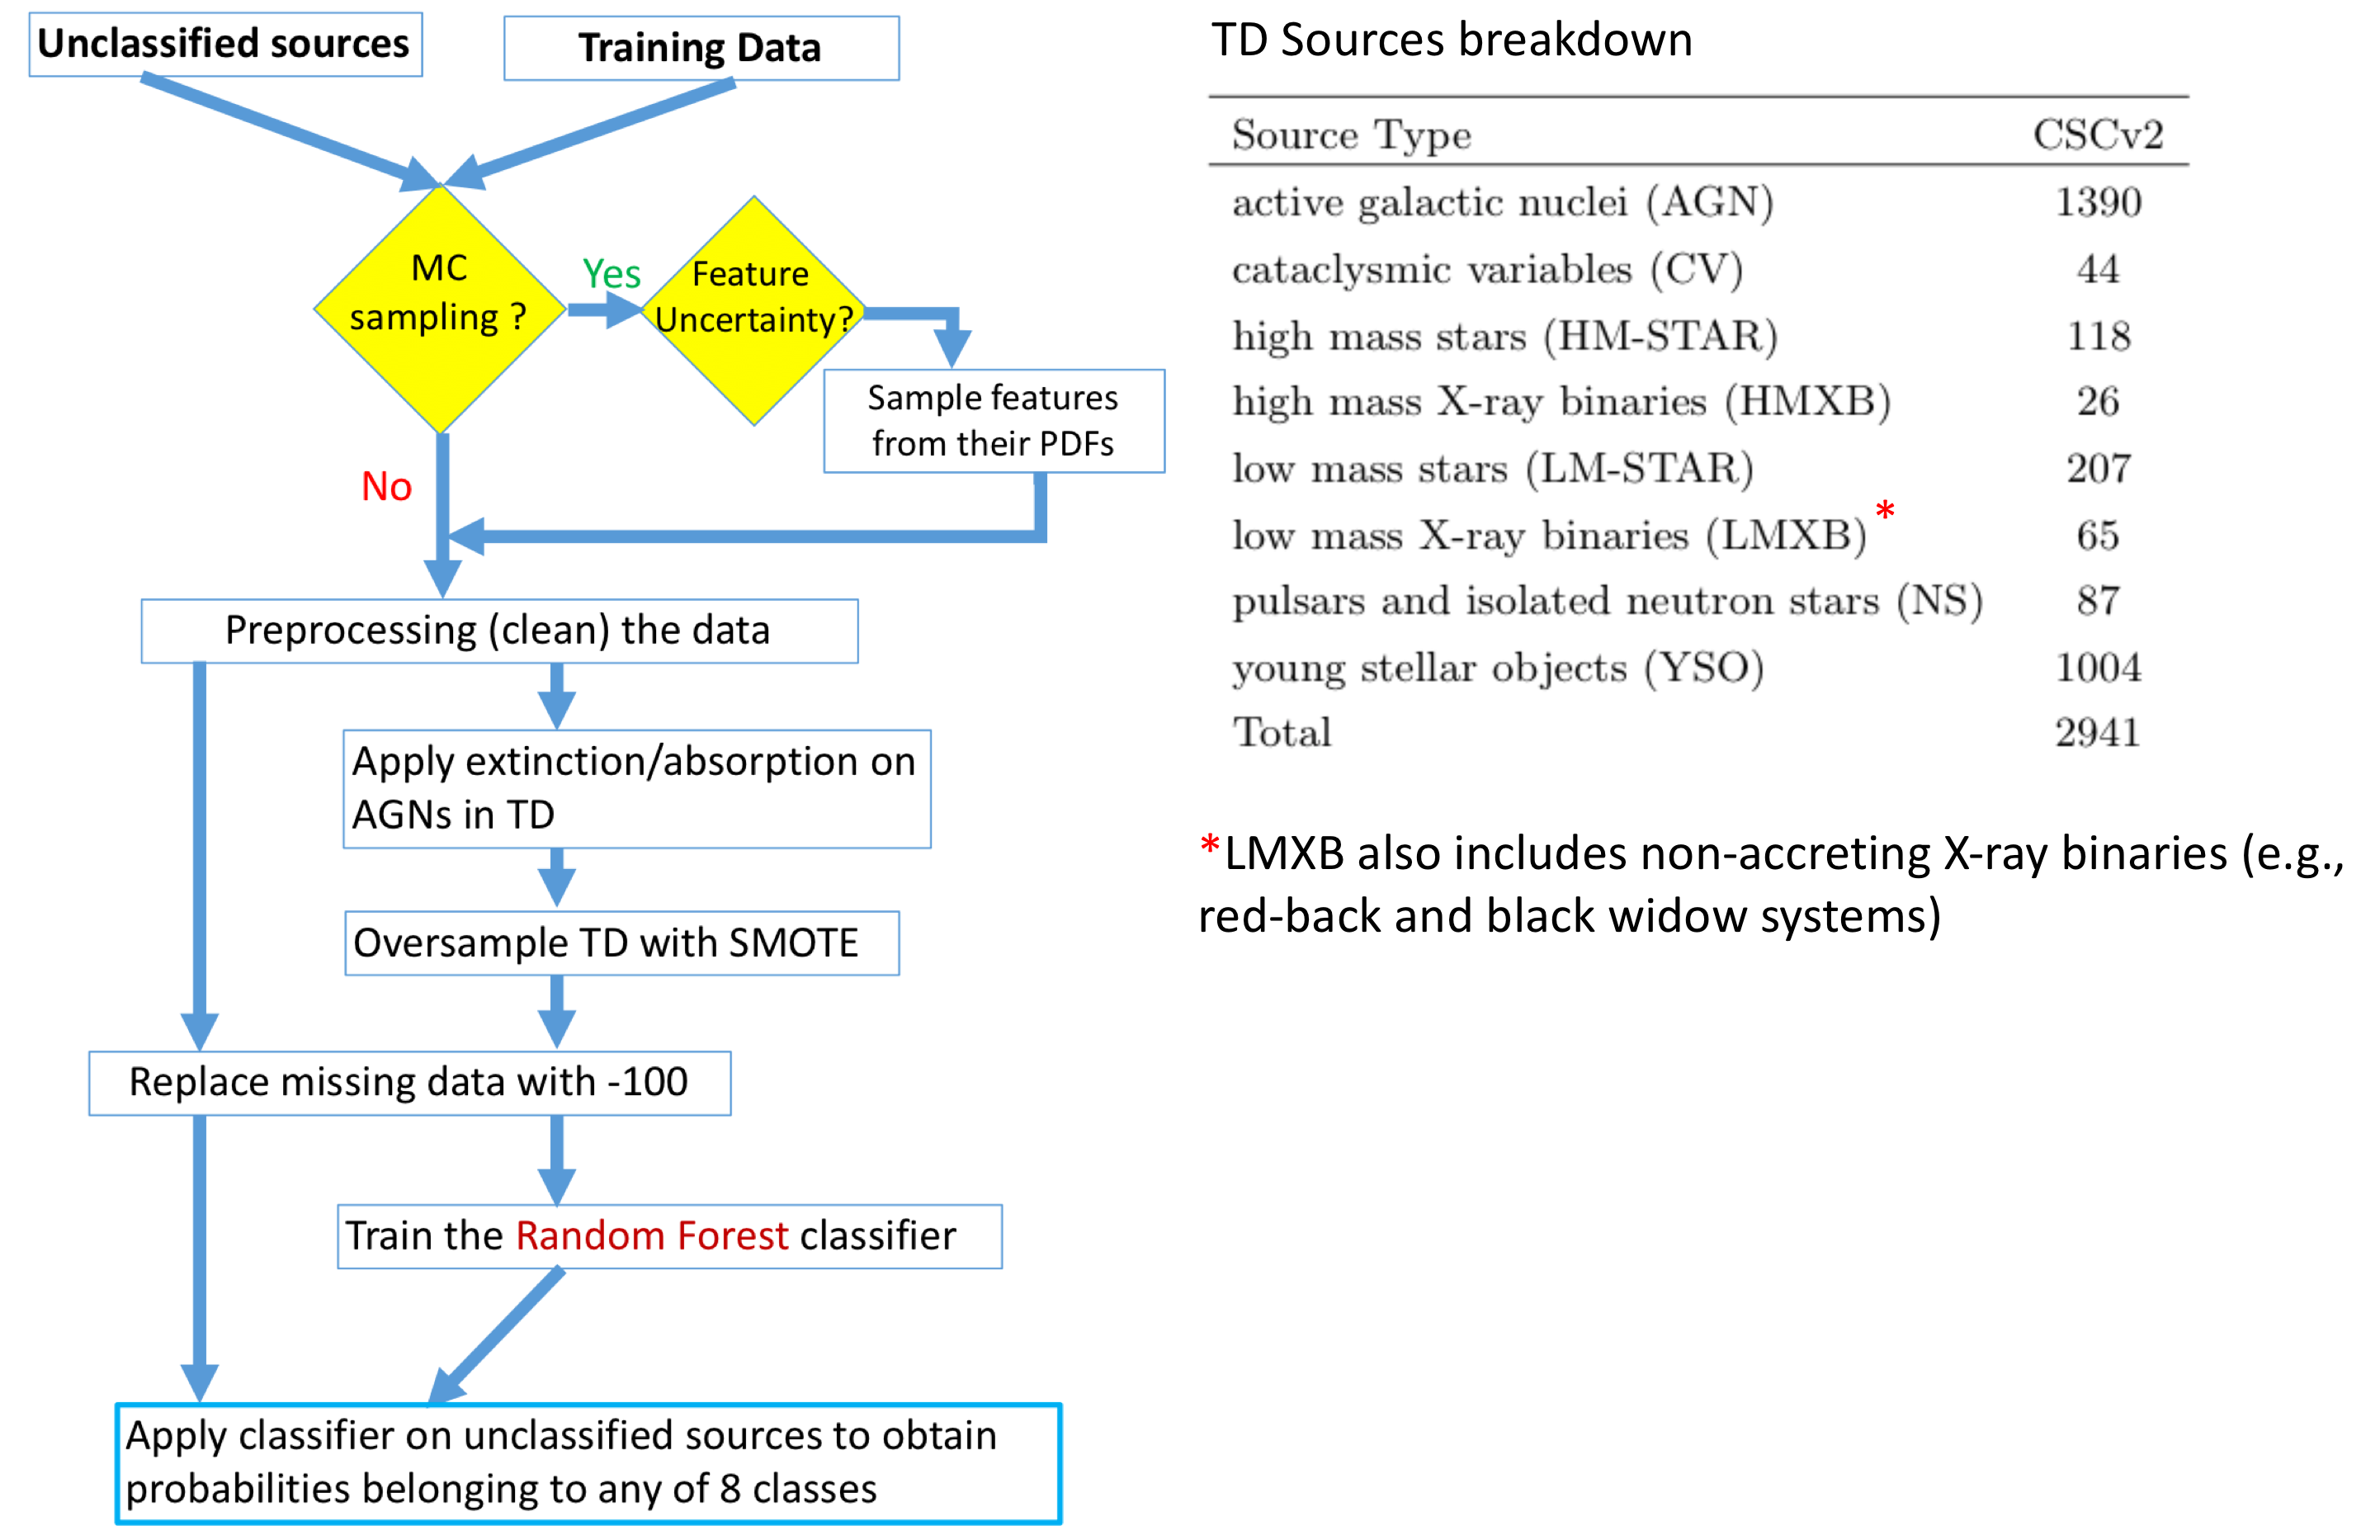

In [7]:
display(Image(filename='../../files/figs/flowchart_TD_breakdown.png',width = 600))

In [35]:
# if you want to use the data from Chandra Source Catalog, set using_CSC = True
# if you want to use the output from your own CXO analysis (or our CSC pipeline), set using_CXO = True

using_CSC = False
using_CXO = True

## Using the Chandra Source Catalog 

#### Define a circular region of interest with detections available from CSCv2 (ACIS chips only)

* field_name
* RA, DEC, radius: RA (right ascension) and Dec (declination) coordinates and radius (in arcmin) of the field

In [8]:

if using_CSC:

    field_name = 'NGC3532'

    RA = 166.28875

    DEC = -58.85

    radius = 12 # in arcmin 



    # Some other examples of regions of interest 

    #field_name = 'Trumpler18'
    #RA, DEC,radius = 167.9712649, -60.6184559, 12
    field_name = 'IC2395'

    RA, DEC,radius = (8.+42./60+30./3600)*15, -(48.+7./60), 12 

    # creating the directories for saving the data and results 

    data_dir = f'./data/{field_name}' # data directory to save the file

    dir_out = f'./{field_name}_results' # classification results directory
    dir_plot = dir_out+'/plot' # plots directory
    Path(dir_out).mkdir(parents=True, exist_ok=True)
    Path(dir_plot).mkdir(parents=True, exist_ok=True)


#### Cone search -- new version using CSCview_conesearch function

* search_engine: The database can be accessed using either curl or wget tool. You may run into some bugs when downloading data using curl, then wget is suggested to use. 
* csc_version: curl can access to different Chandra Source Catalog version, including 2.0 and current version (which includes more data and keeps updating on a daily basis). wget can only access to 2.0 version so the csc_version parameter does not apply to wget 


In [16]:

if using_CSC:
    search_engine = 'curl'#'wget'#'curl'

    # installing wget is required to run with the 'wget' option

    csc_version = 'current' # '2.0'

    df_res = CSCview_conesearch(field_name, RA, DEC, radius,'./data/query',engine=search_engine,csc_version=csc_version)

    #df_res['ra'] = Angle(df_res['ra'], 'hourangle').degree
    #df_res['dec'] = Angle(df_res['dec'], 'deg').degree
    df_res['usrid'] = np.nan
    for i, name in enumerate(df_res['name'].unique()):
        df_res.loc[df_res['name']==name, 'usrid'] = i+1


    # you can filter on the properties of X-ray sources, i.e., X-ray significance if you uncomment the following line

    # df_res = df_res[df_res.significance>=3.].reset_index()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  510k    0  507k  100  3416  84723    556  0:00:06  0:00:06 --:--:--  129k


#### Cone search -- old version since it can not access to CSC Current Database

* query with the PyVo package 
* only significant X-ray sources (significance>=3) are selected for classification, which can be changed to your own purposes

In [4]:
'''
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
field = SkyCoord(RA, DEC, unit="deg") 
maxrad = radius * u.arcmin
results = cone.search(pos=field, radius=maxrad, verbosity=2)
df_res = results.to_table().to_pandas()
df_sig = df_res[df_res.significance>=3.].reset_index()
print(len(df_sig),'sources left with S/N >=3 from',len(df_res), 'sources')
'''

'\ncone = vo.dal.SCSService(\'http://cda.cfa.harvard.edu/csc2scs/coneSearch\')\nfield = SkyCoord(RA, DEC, unit="deg") \nmaxrad = radius * u.arcmin\nresults = cone.search(pos=field, radius=maxrad, verbosity=2)\ndf_res = results.to_table().to_pandas()\ndf_sig = df_res[df_res.significance>=3.].reset_index()\nprint(len(df_sig),\'sources left with S/N >=3 from\',len(df_res), \'sources\')\n'

* prepare_field function extracts per-observation CSC data, calculates average X-ray fluxes and hardness ratio, X-ray variability from multiple X-ray detections, and applies cross-matching with multiwavelength catalogs (GAIA, 2MASS, WISE)


In [4]:
if using_CSC:
    df_MW = prepare_field(df_res, data_dir, './data/query', field_name, name_col='name',Chandratype='CSC',create_perobs=False,convert_hms_to_deg=True)


run create_CXO_ave...
There are 286 per-obs data.
Run nan_flux......
I/350/gaiaedr3
cross-matching to gaia
cross-matching to gaiadist
II/246/out
cross-matching to 2mass
II/365/catwise
cross-matching to catwise
II/363/unwise
cross-matching to unwise
II/328/allwise
cross-matching to allwise
90 counterparts matched for gaia
81 counterparts matched for 2mass
63 counterparts matched for catwise
85 counterparts matched for unwise
67 counterparts matched for allwise


## Or using the outputs from CSC pipeline 

In [36]:
if using_CXO:
    # you need the {obsid}_results.csv, abscor_wav_bright.src, and absolute_wcs_match.log extracted from CSC pipeline
    
    field_name = 'IC2395_CXO'

    RA, DEC,radius = (8.+42./60+30./3600)*15, -(48.+7./60), 12 

    # creating the directories for saving the data and results 

    data_dir = f'./data/{field_name}' # data directory to save the file

    dir_out = f'./{field_name}_results' # classification results directory
    dir_plot = dir_out+'/plot' # plots directory
    Path(dir_out).mkdir(parents=True, exist_ok=True)
    Path(dir_plot).mkdir(parents=True, exist_ok=True)

    # cr = read_file(f'{data_dir}/abscor_wav_bright.src')
    # #print(cr)
    # cols = ['RA','DEC','COMPONENT','SRC_SIGNIFICANCE','NET_COUNTS','NET_COUNTS_ERR']
    # df_wav = pd.DataFrame()
    # for col in cols:
    #     df_wav[col] = cr.get_column(col).values

    hdul = fits.open(data_dir + '/abscor_wav_bright.src')
    src = hdul[1].data
    table = Table(src)
    df_wav = table[['RA','DEC','COMPONENT','SRC_SIGNIFICANCE','NET_COUNTS','NET_COUNTS_ERR']].to_pandas()

    df_res2 = pd.DataFrame()
    for obsid in [21137, 24613]:
        df_obs = pd.read_csv(f'{data_dir}/{obsid}_results.csv')
        df_obs['obsid'] = obsid
        df_obs = pd.merge(df_wav, df_obs, on='COMPONENT', how='outer')
        df_res2 = pd.concat([df_res2, df_obs], ignore_index=True, sort=False)

    pu_astro = get_rms_res(field_name,data_dir,f'{data_dir}/absolute_wcs_match.log')
    #print(pu_astro)

    df_MW = prepare_field(df_res2, data_dir, './data/query', field_name, name_col='name',Chandratype='CXO',pu_astro=pu_astro, create_perobs=False,convert_hms_to_deg=False, gaia_precomputed=True)

run create_CXO_ave...
There are 286 per-obs data.
Run nan_flux......
90 counterparts matched for gaia
81 counterparts matched for 2mass
63 counterparts matched for catwise
85 counterparts matched for unwise
67 counterparts matched for allwise
Launched query: 'SELECT ic2395_cxo.*, gaiaap.*, dist.*, tmass.*, allwise.*
            FROM tap_upload.ic2395_cxo AS ic2395_cxo
            LEFT JOIN gaiadr3.astrophysical_parameters AS gaiaap USING (source_id)
            LEFT JOIN external.gaiaedr3_distance AS dist USING (source_id)
            LEFT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch_tmass USING (source_id)
            LEFT JOIN gaiadr3.tmass_psc_xsc_join AS xjoin_tmass
            ON xmatch_tmass.original_ext_source_id = xjoin_tmass.original_psc_source_id
            LEFT JOIN gaiadr1.tmass_original_valid AS tmass
            ON xjoin_tmass.original_psc_source_id = tmass.designation
            LEFT JOIN gaiadr3.allwise_best_neighbour AS xmatch_allwise USING (source_id)
       

#### read training data , field data and absroption file that is needed to calculate absorption correction 

In [31]:
TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')
TD['Class'] = TD['Class'].replace({'NS_BIN':'LMXB'})
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 

field = pd.read_csv(f'{data_dir}/{field_name}_MW_remove.csv')
print(len(field[field.name.isin(TD.name)]), 'field sources are in the TD:')
print(TD.loc[TD.name.isin(field.name), ['name','Class']])
TD.loc[TD.name.isin(field.name), :].to_csv(f'{data_dir}/TD_{field_name}_MW_remove.csv',index=False)
field = field[~field.name.isin(TD.name)].reset_index(drop=True)
field.to_csv(f'{data_dir}/{field_name}_MW_remove.csv',index=False)

field = prepare_cols(field, cp_thres=0, vphas=False,gaiadata=False) # apply with some filterings

# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('../../files/tbabs.data', skiprows=0)
tbabs_cross *= 100


Remove 21 [('LM-STAR', 1), ('YSO', 20)]
Final breakdown 2941 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 1004)]
0 field sources are in the TD:
Empty DataFrame
Columns: [name, Class]
Index: []


#### MUWCLASS pipeline settings

In [12]:
Xcat = 'CSC' # CSCv2 catalog is used 
Uncer_flag = True # applying Monte-Carlo samplings to account the measurement uncertainties 
num_sample = 100 # number of MC samplings, we use 1000 for our classification results in https://arxiv.org/abs/2206.13656, 100 is runnable with a few minutes on a laptop
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 


#### Preprocessing, including Monte-Carlo sampling of feature uncertainties, applying field-specific reddening on AGNs from the TD, standardization, oversampling to mitigate imbalance in TD (see Section 3 in https://arxiv.org/abs/2206.13656)

In [7]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTEN, KMeansSMOTE

oversample_algorithms = {
    'SMOTE': SMOTE( k_neighbors=4, n_jobs=-1), 
    'ADASYN':ADASYN(n_neighbors=4, n_jobs=-1), 
    'BorderlineSMOTE':BorderlineSMOTE(k_neighbors=4,n_jobs=-1), 
    #'KMeansSMOTE':KMeansSMOTE(cluster_balance_threshold=0.01,k_neighbors=4, n_jobs=-1) 
}

oversample_algo = 'SMOTE' # you can add other oversampling algorithms into the list above and change the algorithm that you want to use here

In [ ]:
# this step takes a few minutes, and it increases linearly as you increase the num_sample (number of MC samplings)

num_cores = mp.cpu_count()
pool = mp.Pool(int(num_cores))

%time arr = [pool.apply(class_prepare_oversample, args=(TD, field, True, RA, DEC, Xcat, 'nodist', Uncer_flag, i, i, tbabs_ene, tbabs_cross,oversample_algorithms[oversample_algo])) for i in range(num_sample)]


#### Our pipeline uses Random Forest (RF) algorithm as the default model. 
#### In this demo, we offer the flexibilities that users can choose their preferred model available from scikit-learn package. 

https://scikit-learn.org/stable/supervised_learning.html


In [10]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

model_dict = {
    'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
    'SVC':SVC(gamma='auto',probability=True), 
    'KNeighbor': KNeighborsClassifier(n_neighbors=10),
    'bagging': BaggingClassifier(), 
    'extratrees': ExtraTreesClassifier(n_estimators=300), 
    'GB': GradientBoostingClassifier()
}

model = 'RF' # you can add models into the model list above and change the model that you want to use here

#### running the classification (training, applying model to field data and saving classification results )

In [11]:
%%time
# this step takes a few minutes

arr2 = list(zip(arr, [model_dict[model]]*len(arr)))

if __name__ == '__main__':
    
    with mp.Pool() as pool:
        res = pool.map(class_train_model_and_classify, arr2) 
#print(res)
class_save_res(res, dir_out)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: user 291 ms, sys: 365 ms, total: 656 ms
Wall time: 20.8 s


#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) 

In [12]:
TD_evaluation = pd.read_csv('../../files/LOO_classes.csv')
field_mw_class = combine_class_result(field_name, data_dir, dir_out, class_labels, TD_evaluation,radius)#,weight_CM=True)

field_XCLASS = field_mw_class.rename(columns={'significance':'Signif.'})




#### select confident classified sources based on Confidence Threshold parameter (see Eq. (7) in https://arxiv.org/abs/2206.13656) for visualization 

In [13]:
CT_cut = 2 # which can be changed

#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) & saving the file for XCLASS plotting

In [14]:
field_XCLASS.loc[field_XCLASS.CT>=CT_cut,['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')


## Visualization of classification results 

### MUWCLASS pipeline performance evaluation 

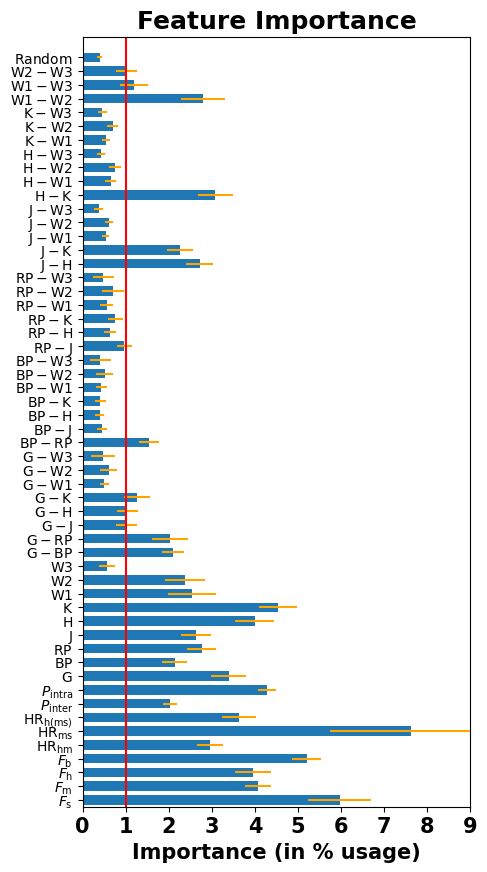

In [20]:
# confusion matrix
recall_cm = plot_confusion_matrix(pd.read_csv('../../files/LOO_classes.csv'),classes=class_labels,title='Norm. Confusion Matrix (%)',width=450,height=400)
show(recall_cm)

# feature importance
feaimps = pd.read_csv('../../files/feature_importance.csv')
fea_imp = plot_Feature_Importance_withSTD(feaimps.iloc[0], feaimps.iloc[1],feaimps.columns,400,800)


### XCLASS interactive plotting website of TD overplotted with field data 

https://home.gwu.edu/~kargaltsev/XCLASS/

* click on Choose File and upload {dir_out}/{field_name}_XCLASS.csv to overplot the field data


#### Visualizing the classification matrix
The classification matrix shows the probability array (the probability to be classified to 8 classes of X-ray emitters from TD) in each row for each source in the field 

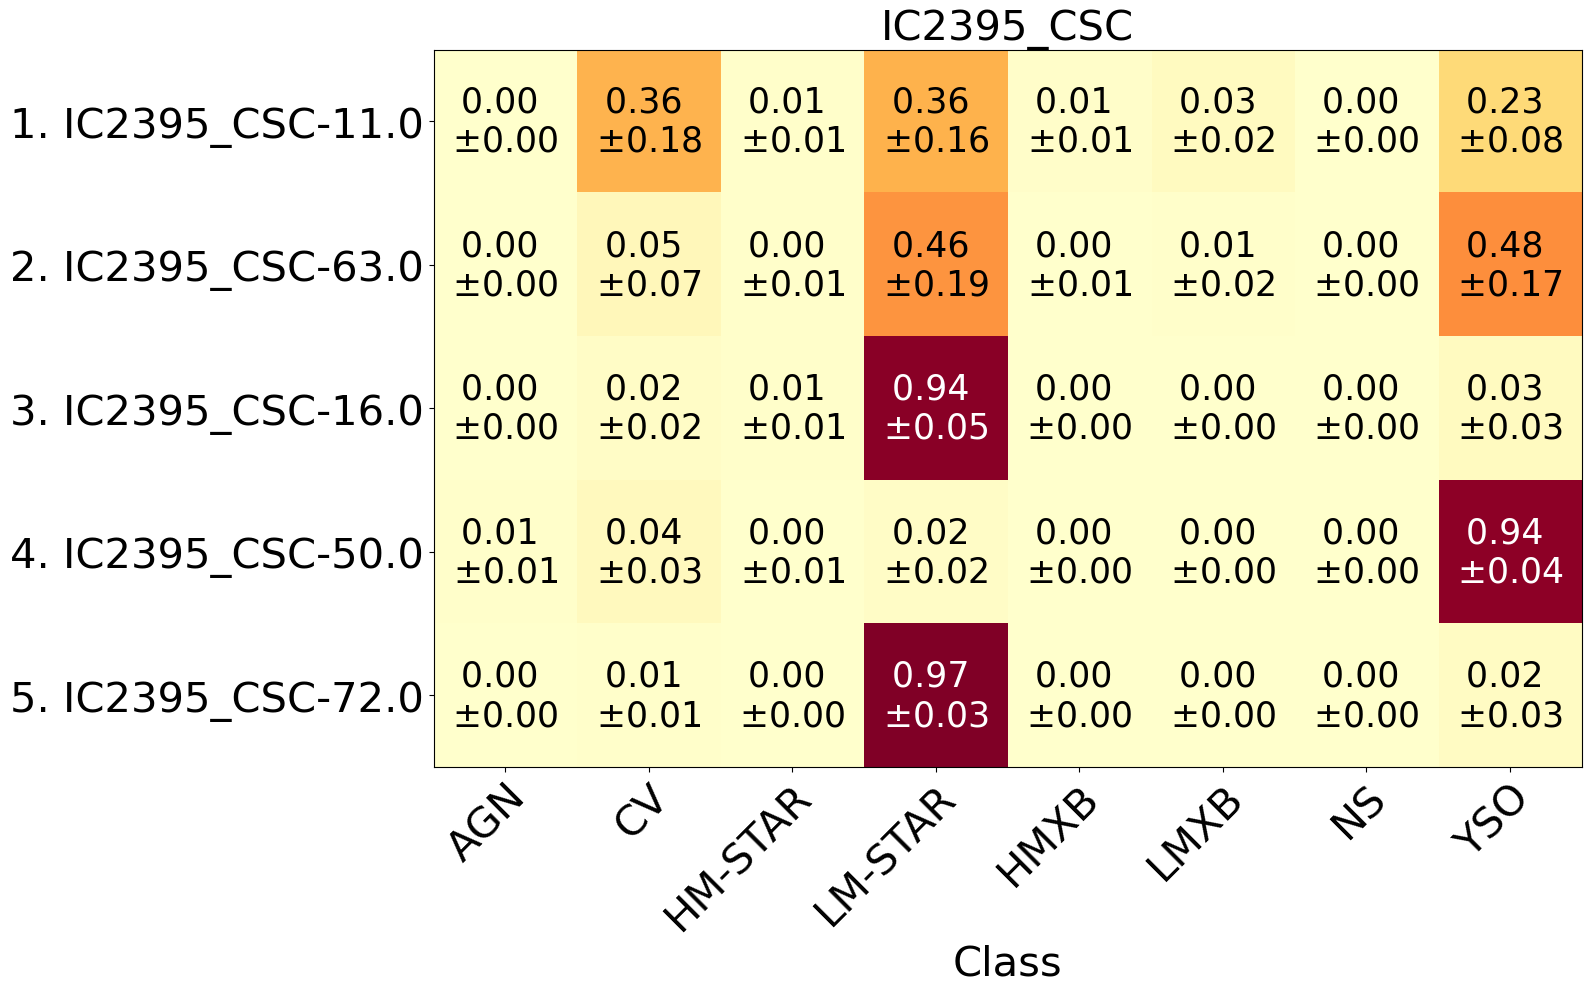

In [15]:
# the sources to plot the classification matrix can be defined by users

# this example plots the top 2 least confidently classified sources and top 3 most confidently classified sources
df_class_matrix = field_mw_class[field_mw_class.CT>0].sort_values(by=['CT'])
df_class_matrix = pd.concat([df_class_matrix.head(2), df_class_matrix.tail(3)])

plot_class_matrix(field_name, df_class_matrix, dir_plot, class_labels)

#### The histograms of all and confident classifications 

<AxesSubplot: title={'center': 'Confident Classification'}>

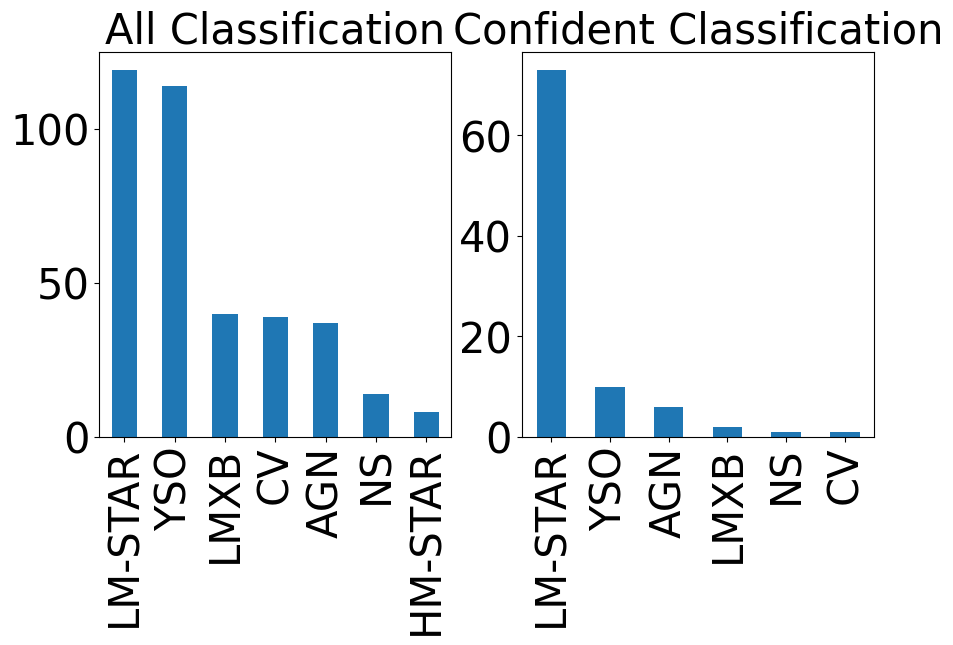

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
field_mw_class['Class'].value_counts().plot(kind='bar', ax=ax1, title='All Classification')
field_mw_class[field_mw_class.CT>=CT_cut]['Class'].value_counts().plot(kind='bar', ax=ax2,title='Confident Classification')


#### multi-band spectrum of TD overplotted with field data (in cyan)
* set plot_classes the classes of sources that you want to plot the broadband SEDs
* The fluxes are normalized so that the medium band fluxes are all the same
* The color indicates the density of the sources from the TD In the multi-band spectrum

In [23]:
TD.columns

Index(['name', 'ra', 'dec', 'PU', 'significance', 'Fcsc_s', 'e_Fcsc_s',
       'Fcsc_m', 'e_Fcsc_m', 'Fcsc_h', 'e_Fcsc_h', 'flux_aper90_ave_b',
       'e_flux_aper90_ave_b', 'var_intra_prob', 'var_inter_prob', 'CSC_flags',
       'EDR3Name_gaia', 'RA_pmcor_gaia', 'DEC_pmcor_gaia', 'Gmag', 'e_Gmag',
       'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Plx', 'e_Plx', 'PM', 'rgeo',
       'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'cp_flag_gaia',
       '_2MASS_2mass', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag',
       'cp_flag_2mass', 'Name_catwise', 'W1mag_catwise', 'e_W1mag_catwise',
       'W2mag_catwise', 'e_W2mag_catwise', 'cp_flag_catwise', 'objID_unwise',
       'W1mag_unwise', 'e_W1mag_unwise', 'W2mag_unwise', 'e_W2mag_unwise',
       'cp_flag_unwise', 'AllWISE_allwise', 'W1mag_allwise', 'e_W1mag_allwise',
       'W2mag_allwise', 'e_W2mag_allwise', 'W3mag', 'e_W3mag', 'W4mag',
       'e_W4mag', 'cp_flag_allwise', 'Class', 'cp_flag_wise12', 'which_wise12',
       'W1m

In [24]:
TD_mw = TD.rename(columns={'Fcsc_s':'F_s','Fcsc_m':'F_m','Fcsc_h':'F_h','flux_aper90_ave_b':'F_b',\
                            'Gmag':'G','BPmag':'BP','RPmag':'RP','Jmag':'J','Hmag':'H','Kmag':'K','W1mag':'W1','W2mag':'W2','W3mag':'W3',\
                            'var_intra_prob':'P_intra', 'var_inter_prob':'P_inter'})

In [26]:
plot_classes = ['YSO','LMXB','LM-STAR','NS','CV','AGN']
plotlist = [plot_bbsed(TD_mw, field_mw_class, dir_plot, plot_class=c, save_class=[], confidence=True, TD_name_col=False) for c in plot_classes]

layout = hv.Layout(plotlist).cols(3)

layout

:Layout
   .Overlay.I   :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.II  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.III :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.IV  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.V   :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)
   .Overlay.VI  :Overlay
      .Scatter.I  :Scatter   [Frequency]   (Flux Norm,Source Density, Flux Norm,Flux,Band)
      .Scatter.II :Scatter   [Frequency]   (Flux Norm,name,Flux,Band)

#### plotting multi-band field images with ipyaladin 

In [28]:

aladin = ipyal.Aladin(target=str(RA)+' '+str(DEC), fov=radius/20)


dtb = QTable.from_pandas(field_mw_class[field_mw_class.conf_flag>0])

aladin

Aladin(fov=0.6, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [53]:
aladin.add_table(dtb)

## Q&A
* What kind of user interface would you like for the MUWCLASS pipeline? 
* Do you have any comments or suggestions that can help us improve the MUWCLASS pipeline?